In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.metrics import dtw
from tslearn.metrics import soft_dtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_soft_dtw_normalized
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/Users/ksmith/Documents/GitHub/Portfolio/Finance Topics/DTW/venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
import robin_stocks.robinhood as r
Username = 'ikris.smith.fin@gmail.com'#Your Robinhood Username/Email
Password = 'dijhon-2zuQpa-jejkyj'#Your Robinhood password
login = r.login(Username,Password, 21600)#You have to use your mfa to pass this

ERROR: There was an issue loading pickle file. Authentication may be expired - logging in normally.


As the number of tradable Ccryptocurrencies keep increasing, portfolio construction to reduce a risk becomes a harder issue. Clustering methods applied on cryptocurrency time series prices can ease this.

Like with stocks, by grouping together similar cryptocurrencies

A method to measure similarity accross each token is important to produce quality conclutions. Typicaly Correlation is used to measure similarity between to assets, but dynamic time warping (DTW) is an alternative that provides a better measure of similarity. I will be demonstrating the use of DTW with 21 Tokens found on Robinhood.

The effectivement of the DTW method in clustering will be evaluated by using the Silhouette index.

## Find and organize Data

In [3]:
raw = r.crypto.get_crypto_currency_pairs(info=None)

code_lst = []
for i in range(0,len(raw)):
    code_lst.append(raw[i]['asset_currency']['code'])
data = pd.DataFrame()
for x in code_lst:
    data[x] = pd.to_numeric(pd.DataFrame(r.crypto.get_crypto_historicals(x, interval='week', span='year', bounds='24_7', info=None))['close_price'])
data=data.pct_change().dropna()

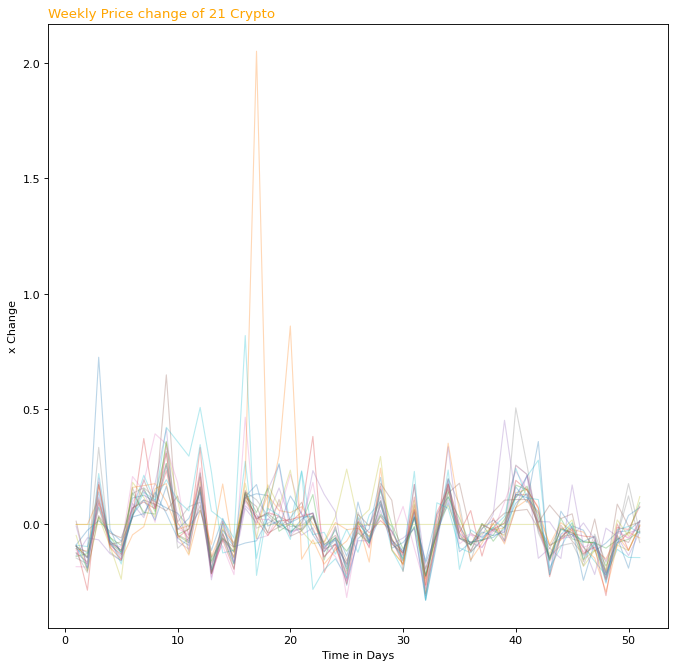

In [4]:
# Plot multiple lines
plt.figure(figsize=(10, 10), dpi=80)

for column in data.columns:
    plt.plot(data.index, data[column],linewidth=1, alpha=0.3,)

 
# Add titles
plt.title("Weekly Price change of 21 Crypto", loc='left', fontsize=12, fontweight=0, color='orange')
plt.ylabel("x Change")
plt.xlabel("Time in Days")

# Show the graph
plt.show()

### EDA

In [5]:
data

,BTC,ETH,BCH,LTC,DOGE,XRP,QTUM,ETC,MATIC,SOL,...,SHIB,XLM,NEO,ZEC,XMR,DASH,BTG,LSK,OMG,BSV
1,-0.088184,-0.105754,-0.094232,-0.093476,-0.134850,-0.123770,-0.182899,-0.145609,-0.047716,-0.089618,...,0.000000,-0.138591,-0.091700,-0.007222,0.014189,-0.111471,-0.122446,0.000000,-0.093014,-0.103730
2,-0.025147,-0.116010,-0.140860,-0.143844,-0.057767,-0.163011,-0.184528,-0.170964,-0.203293,-0.095887,...,0.000000,-0.126220,-0.284915,-0.185876,-0.199123,-0.170768,-0.209068,0.000000,-0.190114,-0.145631
3,0.016656,0.171072,0.102722,0.092431,-0.066723,0.073355,0.200554,0.334094,0.031447,0.076875,...,0.110687,0.032743,0.173474,0.119043,0.038527,0.101908,0.183040,0.000000,0.220732,0.140887
4,-0.029181,-0.078774,-0.054246,-0.073637,-0.126239,-0.086232,-0.094891,-0.119995,-0.092334,-0.062063,...,-0.099656,-0.056695,-0.089262,-0.078766,-0.037581,-0.085073,-0.083161,0.000000,-0.081880,-0.071991
5,-0.072271,-0.117816,-0.120978,-0.111897,-0.157038,-0.075653,-0.152828,-0.157390,-0.237716,-0.171482,...,-0.152672,-0.090945,-0.129323,-0.149964,-0.058167,-0.098279,-0.138806,0.000000,-0.120516,-0.112105
6,0.114707,0.160685,0.039402,0.071806,0.090985,0.032670,0.094936,0.158685,0.182802,0.056993,...,-0.045045,0.137451,0.033972,0.066914,0.071472,0.207790,0.134277,0.000000,0.034200,0.041612
7,0.126541,0.168324,0.156434,0.097323,0.029628,0.193772,0.183562,0.039724,0.117616,0.213196,...,-0.009434,0.052390,0.372479,0.149129,0.106006,0.145585,0.159306,0.000000,0.139865,0.106664
8,0.098922,0.177023,0.056148,0.068257,0.177441,0.075914,0.392943,0.132256,0.030476,0.101462,...,0.155556,0.045058,0.067195,0.071472,0.087626,0.009425,0.117152,0.000000,0.105495,0.018896
9,0.071878,0.099478,0.265049,0.233216,0.415527,0.648493,0.348026,0.316117,0.355823,0.421025,...,0.177198,0.360570,0.308829,0.252183,0.059273,0.336198,0.263256,0.000000,0.194211,0.165317
10,0.048626,-0.021535,-0.043240,0.006930,-0.073915,-0.045136,-0.016679,-0.103068,0.107703,0.359051,...,-0.043174,-0.047789,-0.057865,0.043262,0.123206,0.179740,0.010599,0.000000,0.102915,-0.021110


<AxesSubplot:>

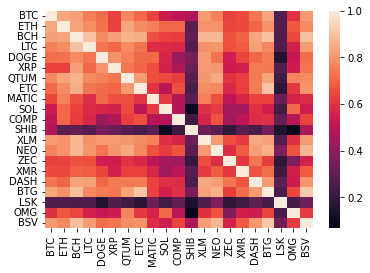

In [6]:
Corr=data.corr()
sns.heatmap(Corr, xticklabels=Corr.columns, yticklabels=Corr.columns)
#1- is perfectly correlated, 0- no correlation

I can identify that SHIB & LSK are outliers 
LSK was started in the last 3 Months and so has no previous data
 SHIB can be considered a 'MEME' Token

In [7]:
data = data.drop(['SHIB','LSK'], axis = 1)

## Clustering

In [8]:
X=data.transpose()
n=3#Number of Clusters I am dictating
seed = 123
np.random.seed(seed)
sz = len(X.columns)

In [9]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=n,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
sdtw_pred = sdtw_km.fit(X)

silhouette_score(cdist_soft_dtw_normalized(X),sdtw_pred.labels_, metric="precomputed",sample_size=300)

Soft-DTW k-means
0.025 --> 0.049 --> 0.049 --> 0.049 --> 


0.4228797536874773

In [10]:
# PCA-kMeans
pca = PCA(n_components=n).fit(X)
pca = KMeans(init=pca.components_, n_clusters=n, n_init=1)
pca_pred= pca.fit(X)


print('mean Silhouette Coefficient :',silhouette_score(X,pca_pred.labels_, metric="euclidean",sample_size=300))

mean Silhouette Coefficient : 0.048956652294679825


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Soft-DTW k-means
0.025 --> 0.049 --> 0.049 --> 0.049 --> 


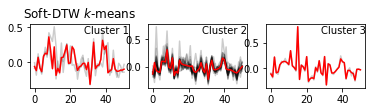

In [11]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_pred = sdtw_km.fit_predict(X)

for yi in range(n):
    plt.subplot(n, n, 2*n+yi+1)
    for index, row in X[sdtw_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Soft-DTW $k$-means")

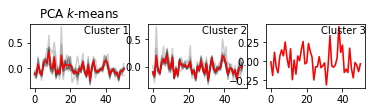

In [12]:
#plt.figure(figsize=(10, 10), dpi=80)

# PCA means
pca_pred = pca_pred.fit_predict(X)
for yi in range(n):
    plt.subplot(n, n, yi + 1)
    for index, row in X[pca_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(pca.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("PCA $k$-means")


#plt.tight_layout()
#plt.show()

# Final Thoughts

What we see is DTW clustering tokens together that and PCA clustering both showing to be effective but DTW is measurably better. An application of using DTW similarity measurments would be in portfolio mixing were instead of using a covariance matrix a DTW similarity matrix could be used in replacement and would offer better portfolio variance control especialy in time similar volatility movements across certain assets which would not be captured by a Covariance matrix.